In [8]:
import numpy as np
from numpy import ma
import math
import scipy
import os
from IPython.display import Image
from tqdm import tqdm

from netCDF4 import Dataset

from cartopy import config
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.cm import get_cmap
from matplotlib import ticker

# from matplotlib.mlab import bivariate_normal

NA = 6.022e+23

In [9]:
FILEDIR = '/n/home12/hongwei/HONGWEI/GC_run_13.0/Final_simulation_continuous_injection/gc_2x25_eulerian_final'
NcFile   = Dataset(FILEDIR+'/OutputDir/GEOSChem.SpeciesConc.20150101_0005z.nc4','r',format='NETCDF4_CLASSIC')

Ap = NcFile.variables['hyai']

del NcFile

In [10]:


# Eulerian 2*2.5
FILEDIR3 = '/n/home12/hongwei/HONGWEI/GC_run_13.0/Final_simulation_continuous_injection/gc_2x25_eulerian_final'
NcFile3   = Dataset(FILEDIR3+'/OutputDir/GEOSChem.SpeciesConc.20150101_0005z.nc4','r',format='NETCDF4_CLASSIC')

lat3             = NcFile3.variables['lat'][:]
lon3             = NcFile3.variables['lon'][:]

# EU3              = NcFile3.variables['SpeciesConc_PASV_EU2']
EU33             = NcFile3.variables['SpeciesConc_PASV_EU']

GC_AREA3 = NcFile3.variables['AREA'][:,:];



# lagrange: 2*2.5
FILEDIR0 = '/n/home12/hongwei/HONGWEI/GC_run_13.0/Final_simulation_continuous_injection/gc_2x25_lagrange_final_V30_Dis10'
NcFile0   = Dataset(FILEDIR0+'/OutputDir/GEOSChem.SpeciesConc.20150101_0005z.nc4','r',format='NETCDF4_CLASSIC')

lat0             = NcFile0.variables['lat'][:]
lon0             = NcFile0.variables['lon'][:]

# LA0              = NcFile0.variables['SpeciesConc_PASV_LA2'][:,:,:,:]
LA00              = NcFile0.variables['SpeciesConc_PASV_LA'][:,:,:,:]
LA03              = NcFile0.variables['SpeciesConc_PASV_LA3'][:,:,:,:]
LA00 = LA00 + LA03

GC_AREA0 = NcFile0.variables['AREA'][:,:];


In [11]:
NcFile0.variables['AREA']

<class 'netCDF4._netCDF4.Variable'>
float32 AREA(lat, lon)
    long_name: Surface area
    units: m2
unlimited dimensions: 
current shape = (91, 144)
filling off

In [12]:


Nx3 = len(EU33[0,0,0,:])
Ny3 = len(EU33[0,0,:,0])
Nz3 = len(EU33[0,:,0,0])
Nt3 = len(EU33[:,0,0,0])


Nx0 = len(LA00[0,0,0,:])
Ny0 = len(LA00[0,0,:,0])
Nz0 = len(LA00[0,:,0,0])
Nt0 = len(LA00[:,0,0,0])

EU33

<class 'netCDF4._netCDF4.Variable'>
float32 SpeciesConc_PASV_EU(time, lev, lat, lon)
    long_name: Dry mixing ratio of species PASV_EU
    units: mol mol-1 dry
    averaging_method: instantaneous
unlimited dimensions: time
current shape = (30, 72, 91, 144)
filling off

In [13]:
del NcFile0, NcFile3

In [17]:
#------------------------------------------------
# total air mass in each grid  ------------------
#------------------------------------------------


# 2x2.5
AD_file3 = Dataset(FILEDIR3+'/OutputDir/GEOSChem.StateMet.20150101_0005z.nc4','r',format='NETCDF4_CLASSIC')
GC_AD3   = AD_file3.variables['Met_AD']

# 2x2.5
AD_file0 = Dataset(FILEDIR0+'/OutputDir/GEOSChem.StateMet.20150101_0005z.nc4','r',format='NETCDF4_CLASSIC')
GC_AD0   = AD_file0.variables['Met_AD']


In [18]:
GC_AD3

<class 'netCDF4._netCDF4.Variable'>
float32 Met_AD(time, lev, lat, lon)
    long_name: Dry air mass
    units: kg
    averaging_method: instantaneous
unlimited dimensions: time
current shape = (30, 72, 91, 144)
filling off

In [19]:
del AD_file0,  AD_file3

In [20]:
# for injected tracer

### change unit, do average


# 2.0x2.5
EU33_molec  = EU33[:,:,:,:]*0.0
EU33_concnt = EU33[:,:,:,:]*0.0

for i in range(Nt3):
    EU33_molec[i,:,:,:]  = EU33[i,:,:,:]*(GC_AD3[i,:,:,:]*1000.0/28.97)*NA # [mol/mol] to [molec]
    EU33_concnt[i,:,:,:] = EU33_molec[i,:,:,:]/GC_AREA3[:,:]/1e4 # [molec/cm2]  
    
EU33_Xmean = np.mean(EU33_concnt[:,:,:,:], axis=3)
    
del EU33


# lagrange: 2.0x2.5
LA00_molec  = LA00[:,:,:,:]*0.0
LA00_concnt = LA00[:,:,:,:]*0.0

for i in range(Nt0):
    LA00_molec[i,:,:,:]  = LA00[i,:,:,:]*(GC_AD0[i,:,:,:]*1000.0/28.97)*NA
    LA00_concnt[i,:,:,:] = LA00_molec[i,:,:,:]/GC_AREA0[:,:]/1e4 # [molec/cm2]  
    
LA00_Xmean = np.mean(LA00_concnt[:,:,:,:], axis=3)
    
del LA00

In [21]:
lev = []
for i in range(len(Ap)-1):
    lev.append( (Ap[i]+Ap[i+1])/2 )
    
np.array(lev[38])

array(52.01591)

In [22]:
# plot  -----------------------------------------
#------------------------------------------------
begin = 33
end = 50

begin_lat = -30
end_lat = 30
begin_hPa = 40
end_hPa = 60

y  = lat0
z  = lev[begin:end]

Y, Z = np.meshgrid(y, z)

# X_max = np.max(LA0_Zsum_Xmean[:,:],axis=(0,1)) # 16.5e+11;

for i in tqdm(np.arange(0,Nt0,1)):
    fig = plt.figure(figsize=(14,5), dpi=300);
#     gs = fig.add_gridspec(15, 8)
    plt.suptitle('Day: '+str(i+1), fontsize=16);
    
    levels = np.arange(1,18,2)*1e12
    norm = colors.BoundaryNorm(boundaries=levels,  ncolors=256)
    
    # (1) for Lagrange ============================================================
    ax1 = plt.subplot(1, 3, 1);
    
    ax1_contours = ax1.contourf(Y, Z, LA00_Xmean[i,begin:end,:], \
                                levels=levels, norm=norm, cmap='Reds', extend="max");
    
    ax1.plot([begin_lat, begin_lat], [begin_hPa, end_hPa], 'k--')
    ax1.plot([end_lat, end_lat], [begin_hPa, end_hPa], 'k--')
    ax1.plot([begin_lat, end_lat], [begin_hPa, begin_hPa], 'k--')
    ax1.plot([begin_lat, end_lat], [end_hPa, end_hPa], 'k--')
    
    plt.gca().invert_yaxis()
    
    cb1 = plt.colorbar(ax1_contours, ax=ax1)
    cb1.ax.tick_params(labelsize=11)
    cb1.set_label('[$molec \cdot m^{-2}$]', fontsize=12)
    
    tick_locs = [-90, -60, -30, 0, 30, 60, 90]
    tick_lbls = ['-90$^\circ$','-60$^\circ$','-30$^\circ$','0$^\circ$','30$^\circ$','60$^\circ$','90$^\circ$']
    ax1.set_xticks(np.array(tick_locs))
    ax1.set_xticklabels(tick_lbls,fontsize=12)
    
    ax1.set_xlabel('Latitude', fontsize=12)
    ax1.set_ylabel('Pressure level [hPa]', fontsize=12)
    ax1.set_ylim([lev[begin],lev[end]])
    ax1.set_title('The PiG model', fontsize=12);
    ax1.set_title('(a)', fontsize=12, loc='left');

    ax1.tick_params(axis='x', labelsize=12)  # to Set Matplotlib Tick Labels Font Size
    ax1.tick_params(axis='y', labelsize=12)
        
     # (2) for EU ==================================================================
    ax2 = plt.subplot(1, 3, 2);
    
    ax2_contours = ax2.contourf(Y, Z, EU33_Xmean[i,begin:end,:], \
                                levels=levels, norm=norm, cmap='Reds', extend="max");
    
    ax2.plot([begin_lat, begin_lat], [begin_hPa, end_hPa], 'k--')
    ax2.plot([end_lat, end_lat], [begin_hPa, end_hPa], 'k--')
    ax2.plot([begin_lat, end_lat], [begin_hPa, begin_hPa], 'k--')
    ax2.plot([begin_lat, end_lat], [end_hPa, end_hPa], 'k--')
    
    plt.gca().invert_yaxis()

    cb2 = plt.colorbar(ax2_contours, ax=ax2)
    cb2.ax.tick_params(labelsize=11)
    cb2.set_label('[$molec \cdot m^{-2}$]')
    
    tick_locs = [-90, -60, -30, 0, 30, 60, 90]
    tick_lbls = ['-90$^\circ$','-60$^\circ$','-30$^\circ$','0$^\circ$','30$^\circ$','60$^\circ$','90$^\circ$']
    ax2.set_xticks(np.array(tick_locs))
    ax2.set_xticklabels(tick_lbls,fontsize=12)
    
    ax2.set_xlabel('Latitude', fontsize=12)
    ax2.set_ylim([lev[begin],lev[end]])
    ax2.set_title('The GEOS-Chem model', fontsize=12);
    ax2.set_title('(b)', fontsize=12, loc='left');
   
    ax2.tick_params(axis='x', labelsize=12)  # to Set Matplotlib Tick Labels Font Size
    ax2.tick_params(axis='y', labelsize=12)
    
    # (3) vertical profile
    ax3 = plt.subplot(1, 3, 3);

    concnt33_vertical = np.sum(EU33_molec[i,:,:,:],axis=(1,2)) /np.sum(GC_AREA3) /1e4
    concnt00_vertical = np.sum(LA00_molec[i,:,:,:],axis=(1,2)) /np.sum(GC_AREA0) /1e4

    ax3.plot( concnt00_vertical[begin:end], lev[begin:end], 'r', label='The PiG model')
    ax3.plot( concnt33_vertical[begin:end], lev[begin:end], 'b--', label='The GEOS-Chem model')
    
    ax3.plot(concnt33_vertical[38], lev[38], 'k.')
    ax3.plot(concnt00_vertical[38], lev[38], 'k.')

    plt.gca().invert_yaxis()
    # plt.yscale('log')
    plt.legend()
    
    ax3.set_ylim([lev[begin],lev[end]])
    ax3.set_xlabel('Concentration [$molec \cdot cm^{-2}$]', fontsize=12)
#     ax3.set_ylabel('vertical level [hPa]')
    
    ax3.tick_params(axis='x', labelsize=12)  # to Set Matplotlib Tick Labels Font Size
    ax3.tick_params(axis='y', labelsize=12)
    ax3.set_title('(c)', fontsize=12, loc='left');
#     ax3.set_title('Global Mean Concentration at different pressure level ', fontsize=12);

    
    plt.tight_layout()
    plt.savefig(str(i+1)+'_yz.png', transparent=False, facecolor='w', edgecolor='w');
    plt.close();
    plt.clf();
    plt.cla();
        
plt.close();

100%|██████████| 30/30 [00:49<00:00,  1.64s/it]


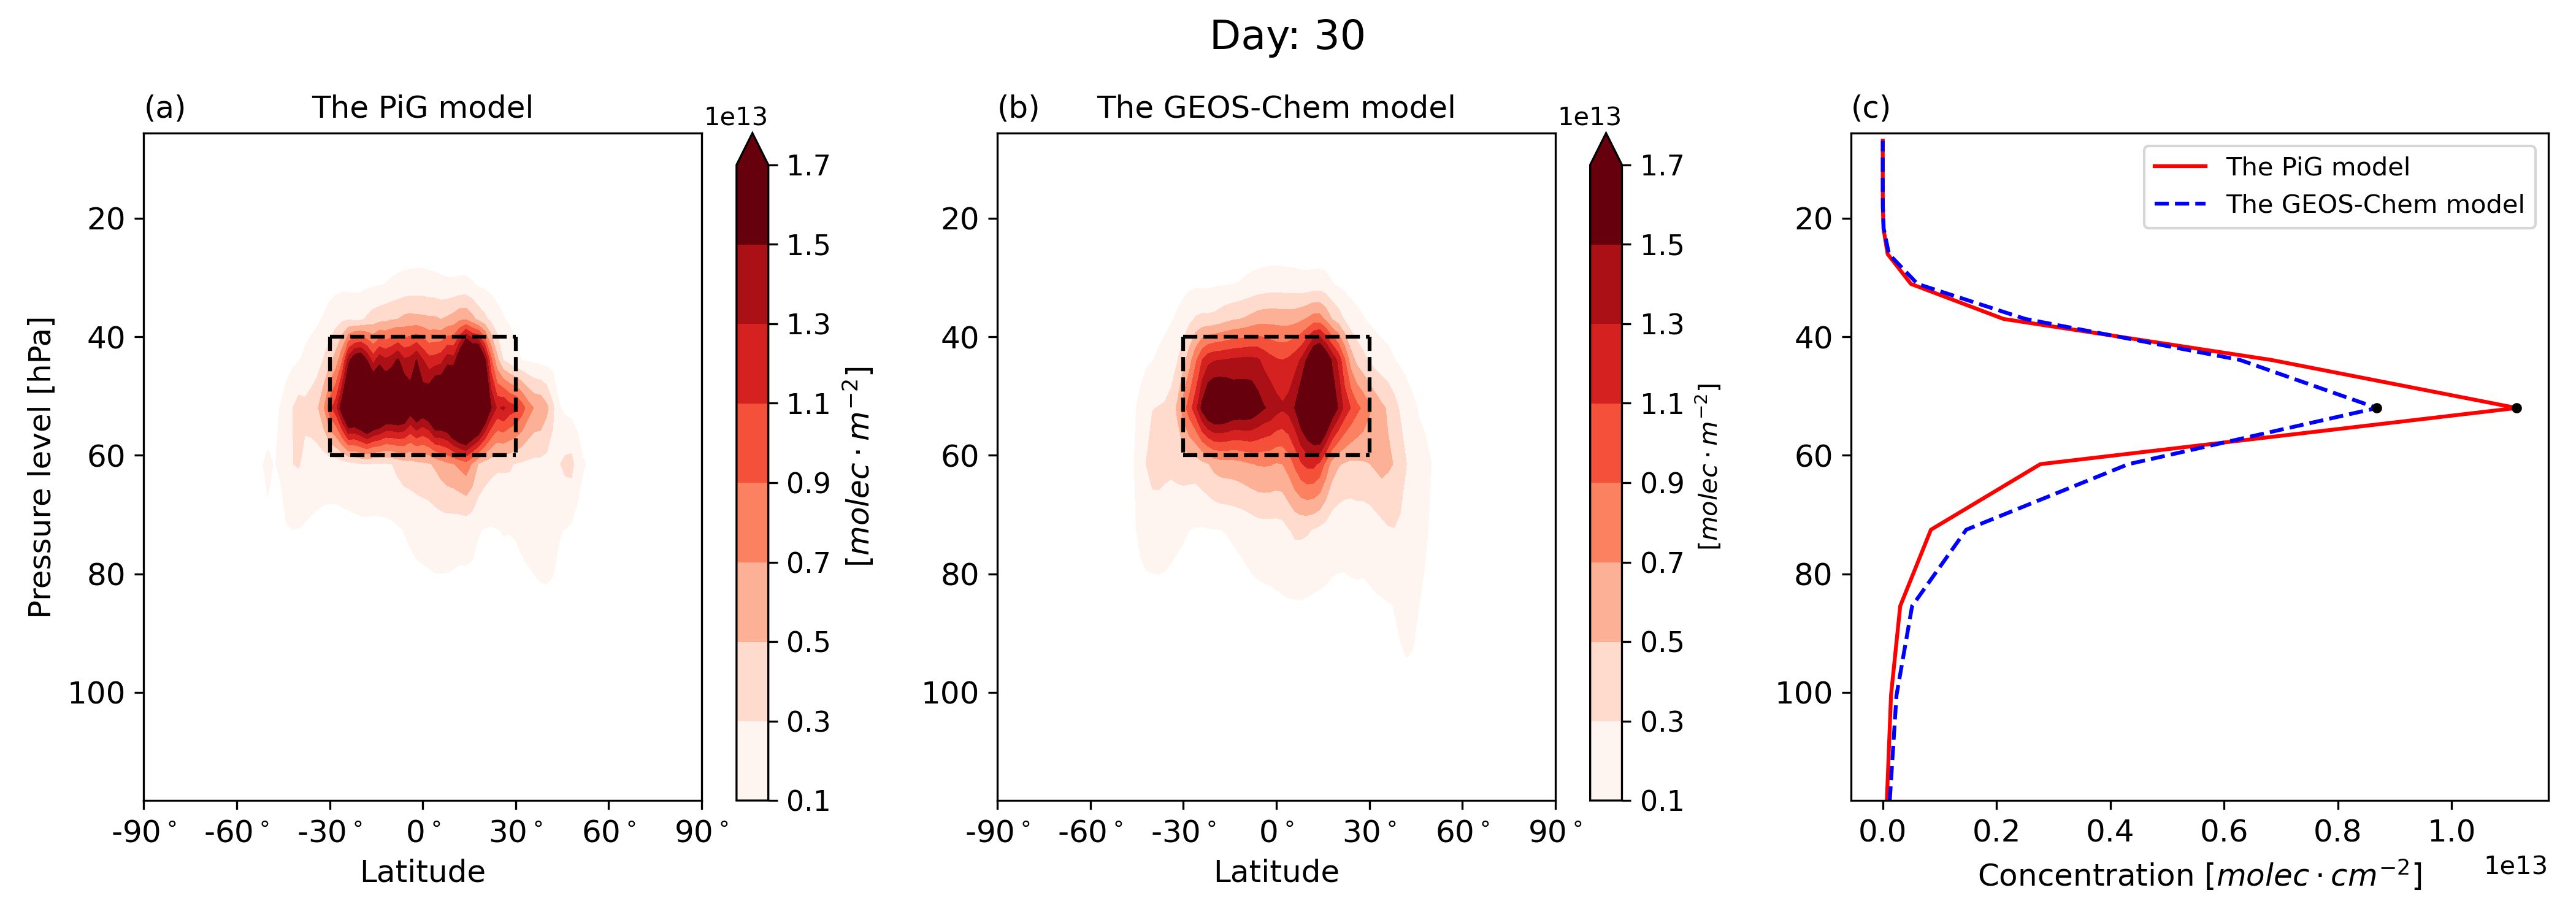

In [23]:
Image(filename=f'30_yz.png')

In [ ]:
k_inject = 38
t = 29

j1 = 30
j2 = 61

mass_LA00 = np.sum(LA00_molec[t,k_inject:k_inject+1,j1:j2,:])
mass_EU33 = np.sum(EU33_molec[t,k_inject:k_inject+1,j1:j2,:])
    
print(lev[k_inject-2],lev[k_inject-1],lev[k_inject],lev[k_inject+1],lev[k_inject+2])
print(lat0[j1:j2])
print(mass_LA00, mass_EU33, (mass_LA00-mass_EU33)/mass_EU33)



In [ ]:
(concnt00_vertical[38]-concnt33_vertical[38])/concnt33_vertical[38]


In [3]:
 Ap[begin:end]

NameError: name 'Ap' is not defined

In [4]:

mass33_vertical = [np.sum(EU33_molec[0,:,:,:]) /np.sum(GC_AREA3)/1e4]
mass00_vertical = [np.sum(LA00_molec[0,:,:,:]) /np.sum(GC_AREA0)/1e4]
days = [0]

Nt = 29
for t in range(29):
    days.append(t+1)
    # print(f'Total tracer mass [molec] in the end: ')
    mass33_vertical.append( np.sum(EU33_molec[t,38,:,:],axis=(0,1)) /np.sum(GC_AREA3)/1e4 ) 
    mass00_vertical.append( np.sum(LA00_molec[t,38,:,:],axis=(0,1)) /np.sum(GC_AREA0)/1e4 ) 
    
    
fig = plt.figure(figsize=(5,3), dpi=150);


plt.plot( days, mass00_vertical, 'r', label='The coupled PiG model')
plt.plot( days, mass33_vertical, 'b', label='The GEOS-Chem model')

plt.xlabel('Day', fontsize=11);
plt.ylabel('Concentration [$molec \cdot cm^{-2}$]', fontsize=11);
plt.legend();

NameError: name 'EU33_molec' is not defined

In [ ]:
plt.plot( days, (np.array(mass00_vertical)-mass33_vertical)/mass00_vertical, '.' )

In [5]:
# max
PD = (np.array(mass00_vertical)-mass33_vertical)/mass33_vertical
np.argmax(PD), PD[np.argmax(PD)], mass00_vertical[np.argmax(PD)], mass33_vertical[np.argmax(PD)]

NameError: name 'mass00_vertical' is not defined

In [6]:
# day 20
mass00_vertical[20], PD[20]

NameError: name 'mass00_vertical' is not defined

In [ ]:
PD[-1]